# Air Quality Time Series

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

### Dataset

In [4]:
url1 = ('https://raw.githubusercontent.com/haojing9058/Time-Series-Air-Quality/refs/heads/master/AirQualityUCI.csv')

aqdf = pd.read_csv(url1, sep=';')

aqdf.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [5]:
aqdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [6]:
aqdf.isnull().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [7]:
# Drop columns 'Unnamed: 15' and 'Unnamed: 16' if they exist
aqdf.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True)

# Drop rows with any missing values (NaN)
aqdf.dropna(inplace=True)

# Show the updated DataFrame
aqdf.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [8]:
aqdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


In [9]:
# Combine Date and Time columns into a single datetime column
aqdf['date_time'] = pd.to_datetime(
    aqdf['Date'] + ' ' + aqdf['Time'].str.replace('.', ':', regex=False),
    format='%d/%m/%Y %H:%M:%S',
    errors='coerce'  # Handle any parsing errors
)

# Drop the original 'Date' and 'Time' columns
aqdf.drop(columns=['Date', 'Time'], inplace=True)

# Set 'date_time' as the index
aqdf.set_index('date_time', inplace=True)

# Display the result
aqdf.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
date_time,,,,,,,,,,,,,
2004-03-10 18:00:00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
2004-03-10 19:00:00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2004-03-10 20:00:00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
2004-03-10 21:00:00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
2004-03-10 22:00:00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [10]:
# Convert only columns with string type to replace commas with dots
for col in aqdf.columns:
    if aqdf[col].dtype == 'object':  # Apply only to string columns
        aqdf[col] = aqdf[col].str.replace(',', '.').astype(float, errors='ignore')

# Display the updated result
aqdf.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
date_time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [11]:
aqdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 1023.4 KB


In [12]:
aqdf.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [13]:
aqdf.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [14]:
zoom = aqdf[aqdf['CO(GT)'] == -200]
zoom

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
date_time,,,,,,,,,,,,,
2004-03-11 04:00:00,-200.0,1011.0,14.0,1.3,527.0,21.0,1818.0,34.0,1197.0,445.0,10.1,60.5,0.7465
2004-03-12 04:00:00,-200.0,831.0,10.0,1.1,506.0,21.0,1893.0,32.0,1134.0,384.0,6.1,65.9,0.6248
2004-03-12 09:00:00,-200.0,1545.0,-200.0,22.1,1353.0,-200.0,767.0,-200.0,2058.0,1588.0,9.2,56.2,0.6561
2004-03-13 04:00:00,-200.0,1147.0,56.0,6.2,821.0,109.0,1132.0,83.0,1412.0,992.0,7.0,71.1,0.7158
2004-03-14 04:00:00,-200.0,1130.0,56.0,5.2,773.0,70.0,1130.0,82.0,1452.0,1051.0,12.1,61.1,0.8603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-03-23 04:00:00,-200.0,993.0,-200.0,2.3,604.0,85.0,848.0,65.0,1160.0,762.0,14.5,66.4,1.0919
2005-03-26 04:00:00,-200.0,1122.0,-200.0,6.0,811.0,181.0,641.0,92.0,1336.0,1122.0,16.2,71.2,1.3013
2005-03-29 04:00:00,-200.0,883.0,-200.0,1.3,530.0,63.0,997.0,46.0,1102.0,617.0,13.7,68.2,1.0611


In [15]:
# Drop rows where the value in the 'CO(GT)' column is equal to -200
aqdf = aqdf[aqdf['CO(GT)'] != -200]

# Replace -200 with the mean of positive values in all numeric columns
aqdf = aqdf.apply(lambda col: col.mask(col == -200, col[col > 0].mean()) if col.dtype in ['float64', 'int64'] else col)

# Display the result
aqdf.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000
mean,2.152750,1110.580746,223.641573,10.275735,947.198121,255.313869,826.920071,114.811932,1444.752723,1043.512936,17.771834,49.060076,0.989453
std,1.453252,213.927135,69.782848,7.279297,259.700177,209.472100,251.068817,46.918066,342.727584,396.752410,8.670013,17.072161,0.391195
min,0.100000,647.000000,7.000000,0.200000,387.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,953.000000,223.641573,4.800000,752.000000,107.000000,657.000000,82.000000,1215.250000,759.000000,11.500000,36.200000,0.714375
50%,1.800000,1087.000000,223.641573,8.900000,934.000000,201.000000,807.000000,114.000000,1444.752723,1013.000000,17.550000,49.060076,0.983950
75%,2.900000,1235.000000,223.641573,14.000000,1116.750000,326.000000,949.000000,141.000000,1659.000000,1287.000000,23.500000,61.800000,1.235200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600


In [16]:
aqdf

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
date_time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.000000,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.000000,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.000000,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.000000,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.000000,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,223.641573,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,223.641573,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,223.641573,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


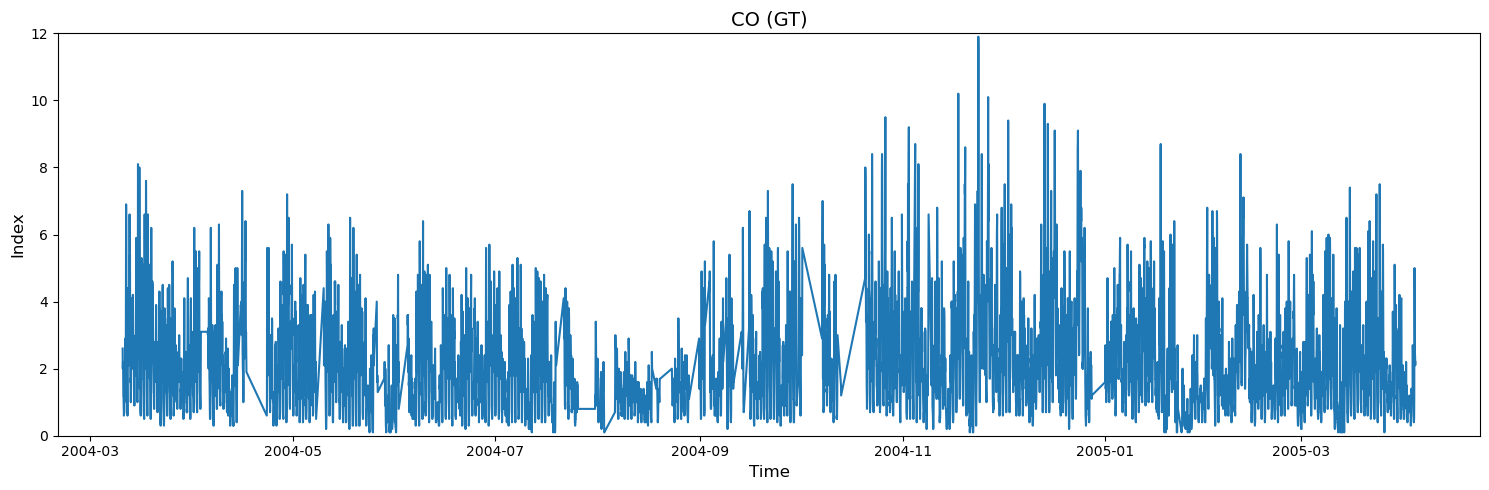

In [17]:
# Ensure index is in datetime format
aqdf.index = pd.to_datetime(aqdf.index)

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))  # Set figure size

# Plot traffic volume using line plot
ax.plot(aqdf.index, aqdf['CO(GT)'])  # Explicitly set datetime index for x-axis

# Formatting
ax.set_xlabel('Time', fontsize=12)  # Set x-axis label
ax.set_ylabel('Index', fontsize=12)  # Set y-axis label
ax.set_title('CO (GT)', fontsize=14)  # Set title

# Set x-limits using not datetime objects
ax.set_ylim(0, 12)

# Show the plot
plt.tight_layout()
plt.show();

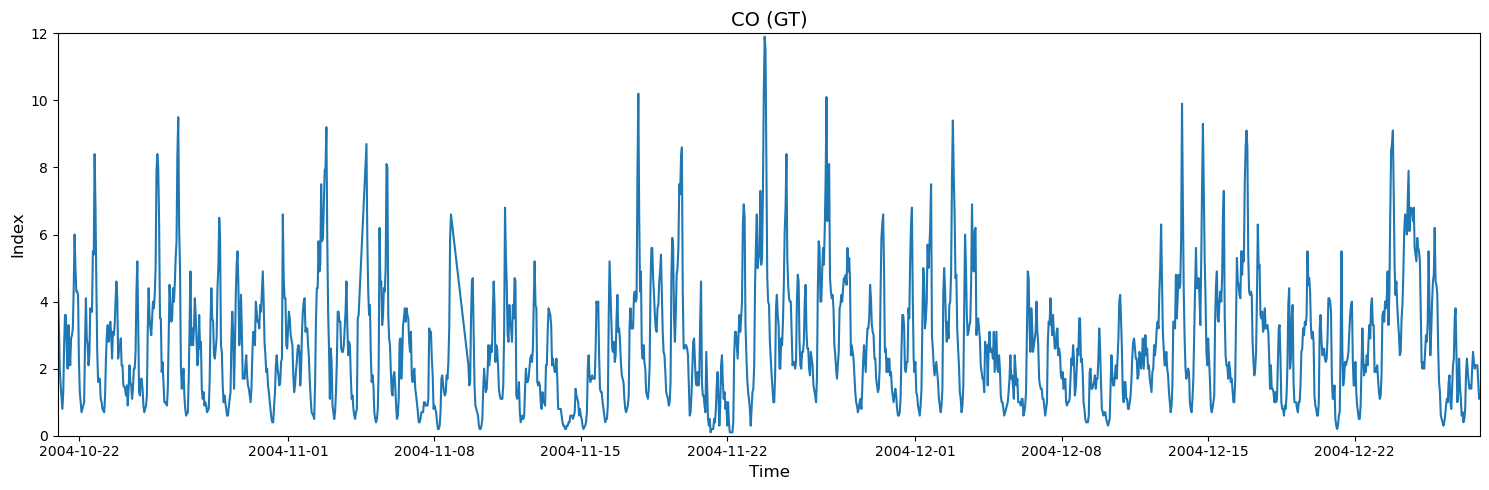

In [18]:
# Ensure index is in datetime format
aqdf.index = pd.to_datetime(aqdf.index)

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))  # Set figure size

# Plot traffic volume using line plot
ax.plot(aqdf.index, aqdf['CO(GT)'])  # Explicitly set datetime index for x-axis

# Formatting
ax.set_xlabel('Time', fontsize=12)  # Set x-axis label
ax.set_ylabel('Index', fontsize=12)  # Set y-axis label
ax.set_title('CO (GT)', fontsize=14)  # Set title

# Set XY-limits
ax.set_ylim(0, 12)
ax.set_xlim(pd.to_datetime('2004-10-21'), pd.to_datetime('2004-12-28'))

# Show the plot
plt.tight_layout()
plt.show();

In [19]:
# Create a subset dataframe 'df' with rows between '2004-10-21' and '2004-12-28'
df = aqdf.loc['2004-10-21':'2004-12-28']

# Display the result
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
date_time,,,,,,,,,,,,,
2004-10-21 00:00:00,4.4,1481.0,223.641573,22.3,1359.0,486.000000,467.0,105.000000,1957.0,1518.0,21.7,69.7,1.7872
2004-10-21 01:00:00,3.3,1289.0,223.641573,15.4,1161.0,335.000000,552.0,91.000000,1765.0,1289.0,21.3,70.3,1.7574
2004-10-21 02:00:00,2.0,1109.0,223.641573,9.3,951.0,210.000000,664.0,77.000000,1570.0,1076.0,20.8,71.7,1.7415
2004-10-21 03:00:00,1.5,994.0,223.641573,6.0,812.0,255.313869,784.0,114.811932,1453.0,947.0,21.4,69.0,1.7421
2004-10-21 05:00:00,0.8,966.0,223.641573,5.1,771.0,149.000000,830.0,60.000000,1420.0,900.0,21.3,69.5,1.7447


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1572 entries, 2004-10-21 00:00:00 to 2004-12-28 00:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         1572 non-null   float64
 1   PT08.S1(CO)    1572 non-null   float64
 2   NMHC(GT)       1572 non-null   float64
 3   C6H6(GT)       1572 non-null   float64
 4   PT08.S2(NMHC)  1572 non-null   float64
 5   NOx(GT)        1572 non-null   float64
 6   PT08.S3(NOx)   1572 non-null   float64
 7   NO2(GT)        1572 non-null   float64
 8   PT08.S4(NO2)   1572 non-null   float64
 9   PT08.S5(O3)    1572 non-null   float64
 10  T              1572 non-null   float64
 11  RH             1572 non-null   float64
 12  AH             1572 non-null   float64
dtypes: float64(13)
memory usage: 171.9 KB


In [21]:
# Ensure the index is sorted for accurate detection
df = df.sort_index()

# Check for discontinuities (gaps) in 'date_time' index
gaps = df.index.to_series().diff().ne('1H')

# Display the rows with detected gaps
gaps_df = df[gaps]
print(f"Number of gaps detected: {gaps_df.shape[0]}")
#gaps_df

Number of gaps detected: 36


In [22]:
aqdf

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
date_time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.000000,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.000000,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.000000,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.000000,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.000000,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,223.641573,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,223.641573,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,223.641573,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


### Data in Days

In [23]:
# Group data by day (removing the hour part) and calculate the mean
aqdf_daily = aqdf.resample('D').mean()

# Display the result
aqdf_daily

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
date_time,,,,,,,,,,,,,
2004-03-10,1.966667,1316.500000,86.500000,8.450000,912.333333,132.000000,1167.333333,108.833333,1545.500000,1096.000000,12.033333,54.900000,0.765633
2004-03-11,2.239130,1254.304348,108.434783,8.269565,866.086957,154.578864,1253.739130,103.383127,1537.000000,904.391304,9.826087,64.230435,0.777039
2004-03-12,2.804545,1290.181818,163.000000,12.177273,1015.454545,184.377903,1081.136364,120.036906,1630.136364,1093.318182,11.618182,50.190909,0.665164
2004-03-13,2.695652,1338.652174,142.869565,11.121739,1000.304348,190.796255,987.173913,120.252693,1603.782609,1256.956522,13.121739,50.682609,0.733013
2004-03-14,2.469565,1371.173913,119.608696,9.830435,951.347826,154.665820,995.695652,111.817910,1608.913043,1242.173913,16.182609,48.317391,0.849209
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-03-31,1.387500,1008.125000,223.641573,5.220833,749.416667,185.083333,795.666667,100.708333,1176.541667,763.833333,17.550000,50.083333,0.951917
2005-04-01,1.108696,907.000000,223.641573,3.526087,671.260870,166.826087,933.391304,110.217391,945.217391,532.695652,16.026087,35.404348,0.631135
2005-04-02,0.854167,890.958333,223.641573,2.529167,616.291667,142.375000,991.750000,100.166667,864.333333,481.750000,15.483333,32.225000,0.546167


In [24]:
aqdf_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 391 entries, 2004-03-10 to 2005-04-04
Freq: D
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         355 non-null    float64
 1   PT08.S1(CO)    355 non-null    float64
 2   NMHC(GT)       355 non-null    float64
 3   C6H6(GT)       355 non-null    float64
 4   PT08.S2(NMHC)  355 non-null    float64
 5   NOx(GT)        355 non-null    float64
 6   PT08.S3(NOx)   355 non-null    float64
 7   NO2(GT)        355 non-null    float64
 8   PT08.S4(NO2)   355 non-null    float64
 9   PT08.S5(O3)    355 non-null    float64
 10  T              355 non-null    float64
 11  RH             355 non-null    float64
 12  AH             355 non-null    float64
dtypes: float64(13)
memory usage: 42.8 KB


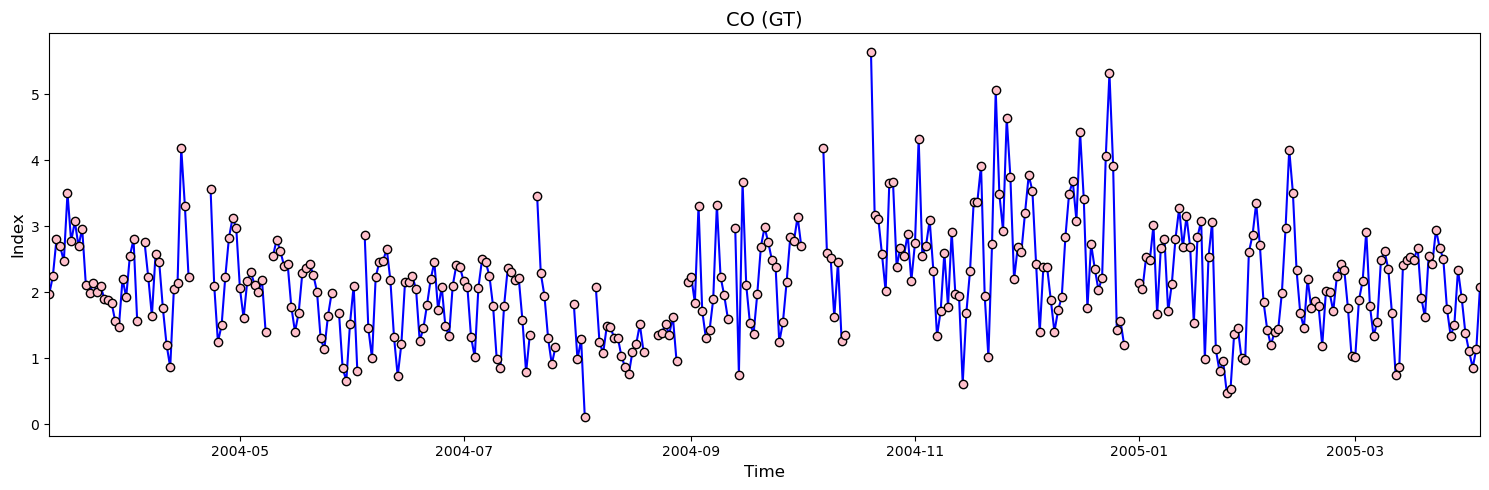

In [25]:
# Ensure index is in datetime format
aqdf.index = pd.to_datetime(aqdf.index)

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plot traffic volume using line plot
ax.plot(aqdf_daily.index, aqdf_daily['CO(GT)'],
        color='blue',               
        marker='o',                 
        markerfacecolor='pink',     
        markeredgecolor='black')    

# Formatting
ax.set_xlabel('Time', fontsize=12)  
ax.set_ylabel('Index', fontsize=12)  
ax.set_title('CO (GT)', fontsize=14)  

# Set XY-limits
#ax.set_ylim(0, 12)
ax.set_xlim(pd.to_datetime('2004-03-10'), pd.to_datetime('2005-04-04'))

# Show the plot
plt.tight_layout()
plt.show();

In [26]:
# Interpolation for smoother values (linear)
aqdf_daily_filled = aqdf_daily.interpolate(method='linear')

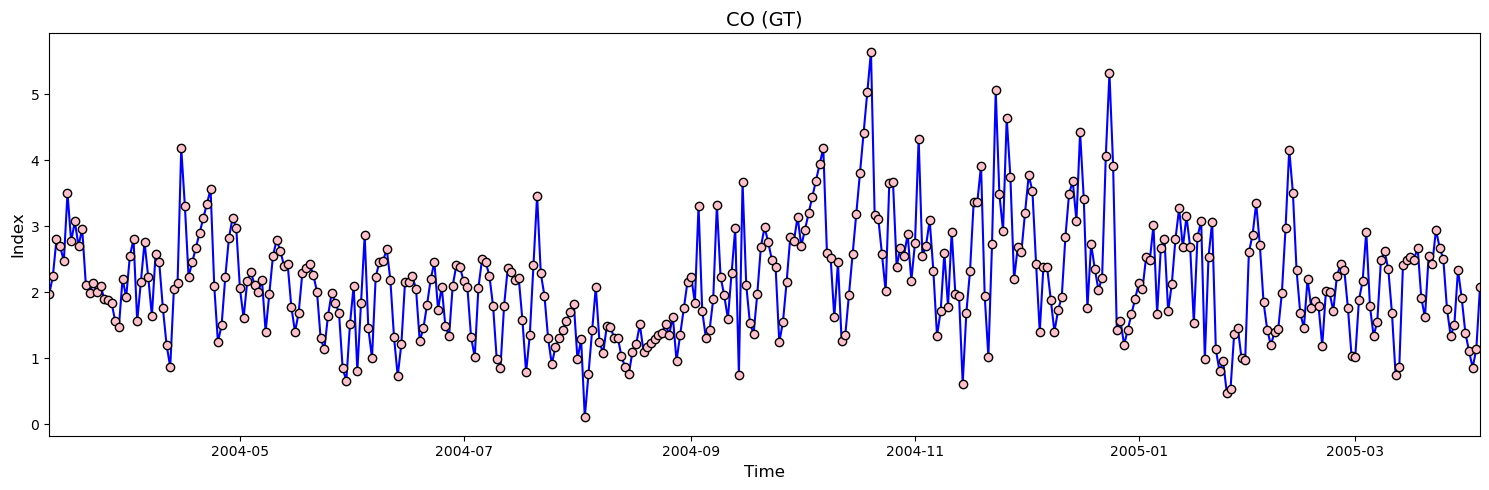

In [27]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5)) 

# Plot traffic volume using line plot
ax.plot(aqdf_daily_filled.index, 
        aqdf_daily_filled['CO(GT)'],
        color='blue',               
        marker='o',                 
        markerfacecolor='pink',     
        markeredgecolor='black')  

# Formatting
ax.set_xlabel('Time', fontsize=12)  
ax.set_ylabel('Index', fontsize=12)  
ax.set_title('CO (GT)', fontsize=14)  

# Set XY-limits
#ax.set_ylim(0, 12)
ax.set_xlim(pd.to_datetime('2004-03-10'), pd.to_datetime('2005-04-04'))

# Show the plot
plt.tight_layout()
plt.show();

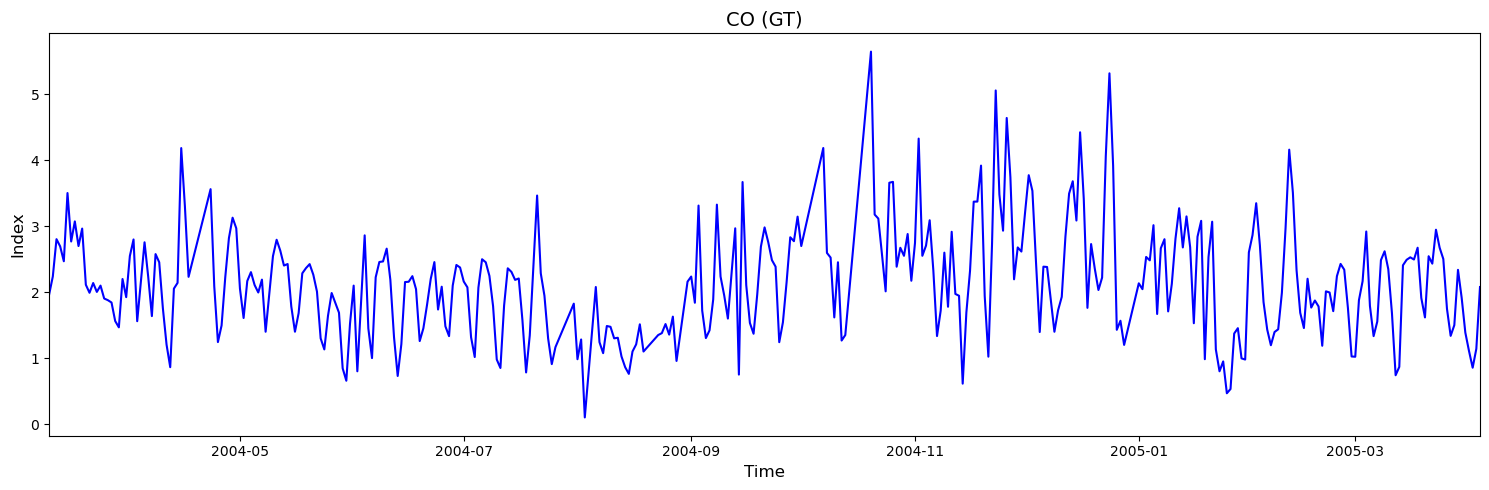

In [28]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5)) 

# Plot traffic volume using line plot
ax.plot(aqdf_daily_filled.index, 
        aqdf_daily_filled['CO(GT)'],
        color='blue')  

# Formatting
ax.set_xlabel('Time', fontsize=12)  
ax.set_ylabel('Index', fontsize=12)  
ax.set_title('CO (GT)', fontsize=14)  

# Set XY-limits
#ax.set_ylim(0, 12)
ax.set_xlim(pd.to_datetime('2004-03-10'), pd.to_datetime('2005-04-04'))

# Show the plot
plt.tight_layout()
plt.show();

# SARIMAX

In [29]:
# Split the data
cutoff = pd.to_datetime("2005-03-01")

train = aqdf_daily_filled[aqdf_daily_filled.index < cutoff]
test = aqdf_daily_filled[aqdf_daily_filled.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (356, 13)
Test shape: (35, 13)

              CO(GT)  PT08.S1(CO)    NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
date_time                                                                
2005-02-24  2.243478  1153.173913  223.641573  8.917391     906.869565   
2005-02-25  2.429167  1129.541667  223.641573  9.541667     937.000000   
2005-02-26  2.341667  1001.750000  223.641573  5.304167     768.250000   
2005-02-27  1.760870   971.304348  223.641573  4.395652     721.086957   
2005-02-28  1.025000   834.250000  223.641573  2.637500     606.791667   

               NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
date_time                                                                     
2005-02-24  387.883212    705.739130  204.252693   1231.347826  1132.043478   
2005-02-25  327.955900    697.833333  156.809825   1212.041667  1099.791667   
2005-02-26  227.929745    844.250000  128.908830    999.083333   835.041667   
2005-02-27  213.231038    898.869565  127

In [30]:
cog_series = train['CO(GT)']

In [31]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(cog_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -2.7260, p-value = 0.0696
d = 1 | ADF Statistic = -9.5799, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [32]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(cog_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0


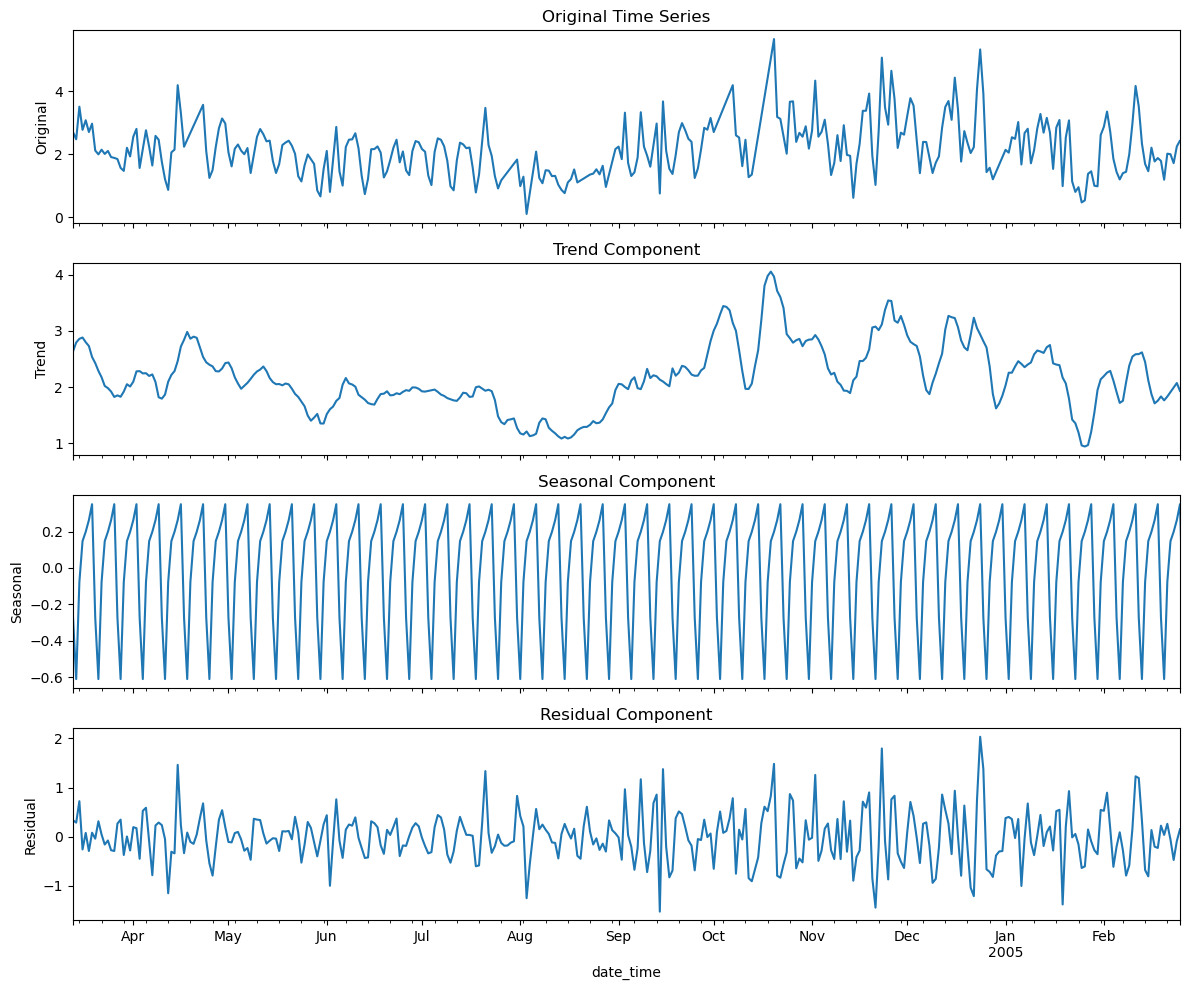

In [33]:
result = seasonal_decompose(cog_series, model='aditive', period=7)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

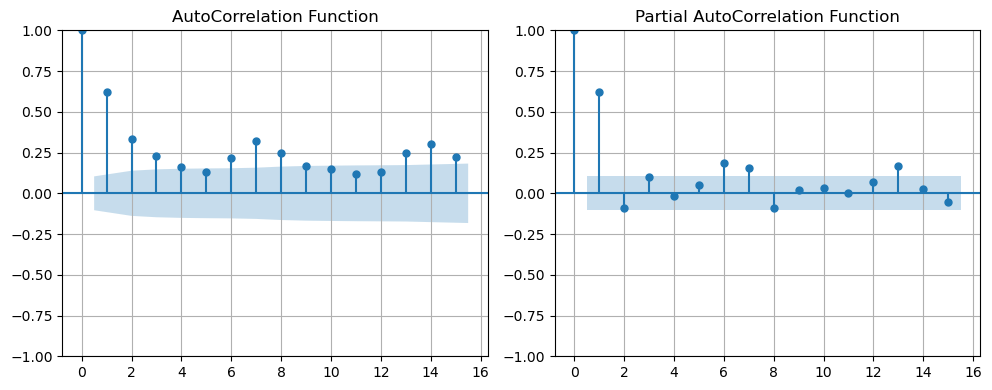

In [34]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


acf_and_pacf(cog_series, lagsn=15)

In [35]:
def best_auto_arima(series, d=0, D=0, S=12):

    # Perform a full search over the same grid as your manual SARIMAX model
    auto_model = pm.auto_arima(
        series,                     # The time series data
        seasonal=True,              # Enable seasonal component
        m=S,                        # Seasonal period
        d=d,                        # Set differencing 
        D=D,                        # Set seasonal differencing
        start_p=0, max_p=3,         # p 
        start_q=0, max_q=3,         # q 
        start_P=0, max_P=3,         # P 
        start_Q=0, max_Q=3,         # Q 
        stepwise=False,             # Disable stepwise search (enable full grid search)
        trace=False,                # Print model search progress
        error_action='ignore',      # Ignore errors and continue
        suppress_warnings=True,     # Suppress convergence warnings
        information_criterion='aic' # Use AIC to choose the best model
    )

    # Print the best model found
    print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

best_auto_arima(cog_series, d=1, D=0, S=7)

Best model: SARIMA(1, 1, 2)(1, 0, 1, 7)


In [36]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(series, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]              # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]                # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 15 == 0:                                  # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(series,                              # Define SARIMA model with current parameter set
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(series=cog_series, d=1, D=0, S=7)

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,7)
Running model #15 using SARIMA(0,1,0)(3,0,3,7)
Running model #30 using SARIMA(0,1,1)(3,0,2,7)
Running model #45 using SARIMA(0,1,2)(3,0,1,7)
Running model #60 using SARIMA(0,1,3)(3,0,0,7)
Running model #75 using SARIMA(1,1,0)(2,0,3,7)
Running model #90 using SARIMA(1,1,1)(2,0,2,7)
Running model #105 using SARIMA(1,1,2)(2,0,1,7)
Running model #120 using SARIMA(1,1,3)(2,0,0,7)
Running model #135 using SARIMA(2,1,0)(1,0,3,7)
Running model #150 using SARIMA(2,1,1)(1,0,2,7)
Running model #165 using SARIMA(2,1,2)(1,0,1,7)
Running model #180 using SARIMA(2,1,3)(1,0,0,7)
Running model #195 using SARIMA(3,1,0)(0,0,3,7)
Running model #210 using SARIMA(3,1,1)(0,0,2,7)
Running model #225 using SARIMA(3,1,2)(0,0,1,7)
Running model #240 using SARIMA(3,1,3)(0,0,0,7)
Running model #255 using SARIMA(3,1,3)(3,0,3,7)

Best models by AIC:
   index non-seasonal order seasonal order         AIC
0    111          (1, 1, 2)      (3, 0, 

In [37]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_112 = SARIMAX(cog_series,                     # Time series data
                    order=(1, 1, 2),                # Non-seasonal order (p,d,q)
                    seasonal_order=(3, 0, 3, 7),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_112 = model_112.fit()

# Display summary of the model
print(model_fit_112.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                    CO(GT)   No. Observations:                  356
Model:             SARIMAX(1, 1, 2)x(3, 0, [1, 2, 3], 7)   Log Likelihood                -323.851
Date:                                   Fri, 09 May 2025   AIC                            667.703
Time:                                           14:25:34   BIC                            705.724
Sample:                                       03-10-2004   HQIC                           682.867
                                            - 02-28-2005                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4039      0.103      3.929      0.000    

In [38]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")


test_parameters(model_fit_112)

ma.L2 coefficient: -0.1656
ma.L2 95% CI: (-0.3353, 0.0040)
ma.L2 p-value: 0.0556
ma.L2 is statistically IRRELEVANT in the model.

ar.S.L7 coefficient: -0.1119
ar.S.L7 95% CI: (-0.9661, 0.7424)
ar.S.L7 p-value: 0.7975
ar.S.L7 is statistically IRRELEVANT in the model.

ar.S.L21 coefficient: 0.3615
ar.S.L21 95% CI: (-0.3743, 1.0974)
ar.S.L21 p-value: 0.3356
ar.S.L21 is statistically IRRELEVANT in the model.

ma.S.L7 coefficient: 0.1985
ma.S.L7 95% CI: (-0.6446, 1.0416)
ma.S.L7 p-value: 0.6444
ma.S.L7 is statistically IRRELEVANT in the model.

ma.S.L21 coefficient: -0.3708
ma.S.L21 95% CI: (-1.0640, 0.3224)
ma.S.L21 p-value: 0.2945
ma.S.L21 is statistically IRRELEVANT in the model.



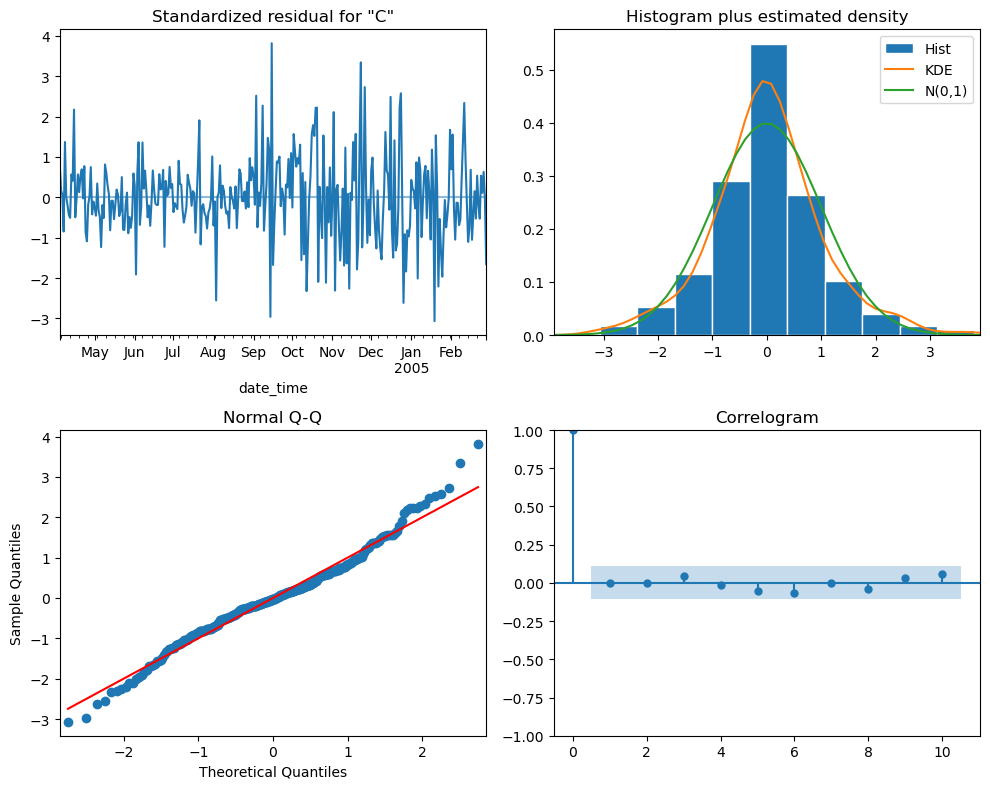

In [39]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_112.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [40]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_110 = SARIMAX(cog_series,                     # Time series data
                    order=(1, 1, 2),                # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 1, 7),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_110 = model_110.fit()

# Display summary of the model
print(model_fit_110.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              CO(GT)   No. Observations:                  356
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -339.265
Date:                             Fri, 09 May 2025   AIC                            690.529
Time:                                     14:25:35   BIC                            713.590
Sample:                                 03-10-2004   HQIC                           699.713
                                      - 02-28-2005                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4166      0.102      4.079      0.000       0.216       0.617
ma.L1         -0.7768      

In [41]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")


test_parameters(model_fit_110)

ma.L2 coefficient: -0.1464
ma.L2 95% CI: (-0.3128, 0.0199)
ma.L2 p-value: 0.0845
ma.L2 is statistically IRRELEVANT in the model.



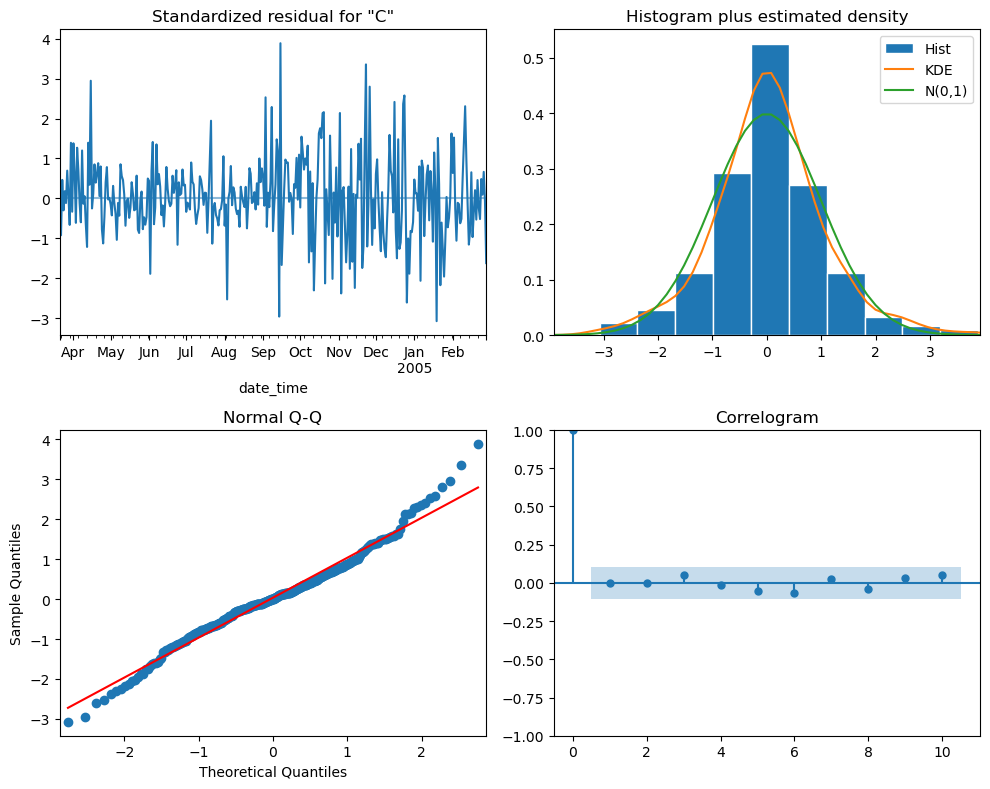

In [42]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_110.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [43]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_110.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.105869,0.744898
2,0.156589,0.924692
3,0.919878,0.820628
4,0.968694,0.914505
5,1.345012,0.930233
6,3.028643,0.805243
7,3.104485,0.875171
8,3.825710,0.872496
9,4.295053,0.890942
10,4.607720,0.915797


In [44]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.9989
Conclusion: No significant autocorrelation.


In [45]:
# Forecast the next Time points
forecast_S = model_fit_110.get_forecast(steps=test.shape[0])

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                                # Forecast mean

test['Error'] = test['Forecast S'] - test['CO(GT)']

test['Lower 95% CI'] = conf_int_S.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_S.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Forecast S,Error,Lower 95% CI,Upper 95% CI
date_time,,,,,,,,,,,,,,,,,
2005-03-01,1.020833,820.166667,223.641573,2.933333,618.916667,185.721411,1191.833333,100.075497,699.083333,482.708333,1.433333,35.104167,0.240004,1.472557,0.451724,0.235837,2.709277
2005-03-02,1.878261,978.782609,223.641573,7.756522,846.782609,334.752777,887.304348,151.426606,883.304348,1001.521739,4.534783,31.478261,0.251748,1.771082,-0.107179,0.302871,3.239293
2005-03-03,2.166667,1184.291667,223.641573,8.150000,884.708333,375.721411,686.833333,157.700497,1162.416667,1304.250000,4.591667,67.458333,0.577546,1.987961,-0.178706,0.459574,3.516348
2005-03-04,2.920833,1214.791667,223.641573,11.408333,994.916667,437.471411,650.458333,168.117164,1282.333333,1369.750000,7.187500,62.191667,0.620279,2.166218,-0.754615,0.613837,3.718599
2005-03-05,1.791304,1052.521739,223.641573,6.465217,824.869565,262.578864,778.869565,151.122258,1057.391304,919.173913,8.400000,51.413043,0.543839,1.770033,-0.021272,0.203746,3.336319


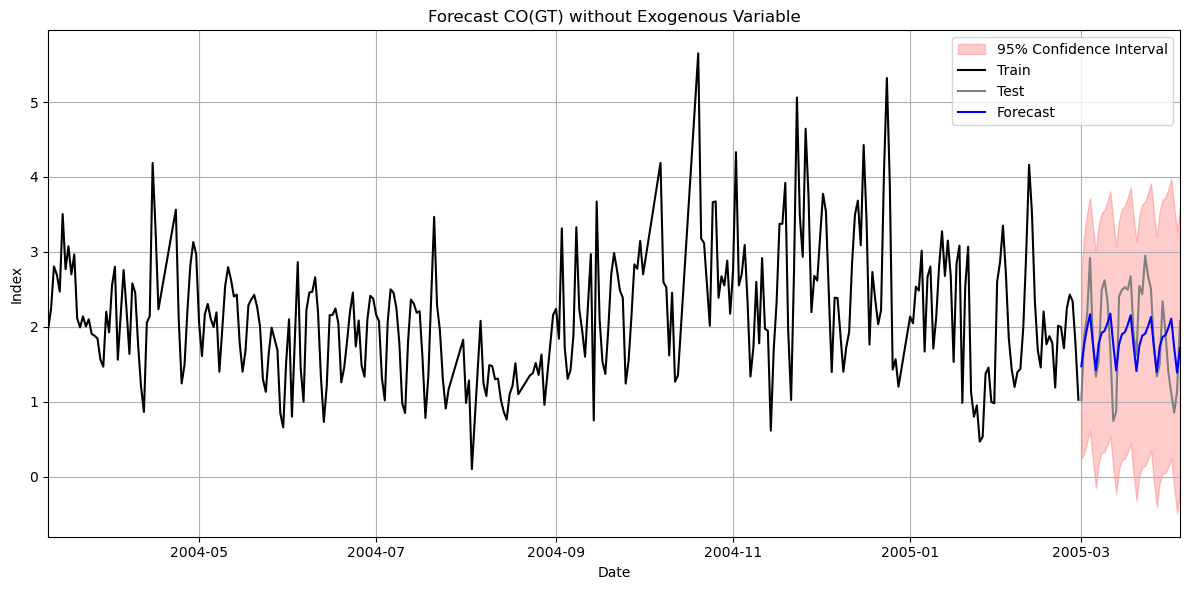

In [46]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['CO(GT)'], label='Train', color='black')       # Train
plt.plot(test.index, test['CO(GT)'], label='Test', color='gray')           # Test

plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')   # Forecast

plt.title('Forecast CO(GT) without Exogenous Variable')                      
plt.xlabel('Date')                                        
plt.ylabel('Index')  
plt.xlim(pd.to_datetime('2004-03-10'), pd.to_datetime('2005-04-04'))

# Set y-axis to avoid scientific notation
#plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

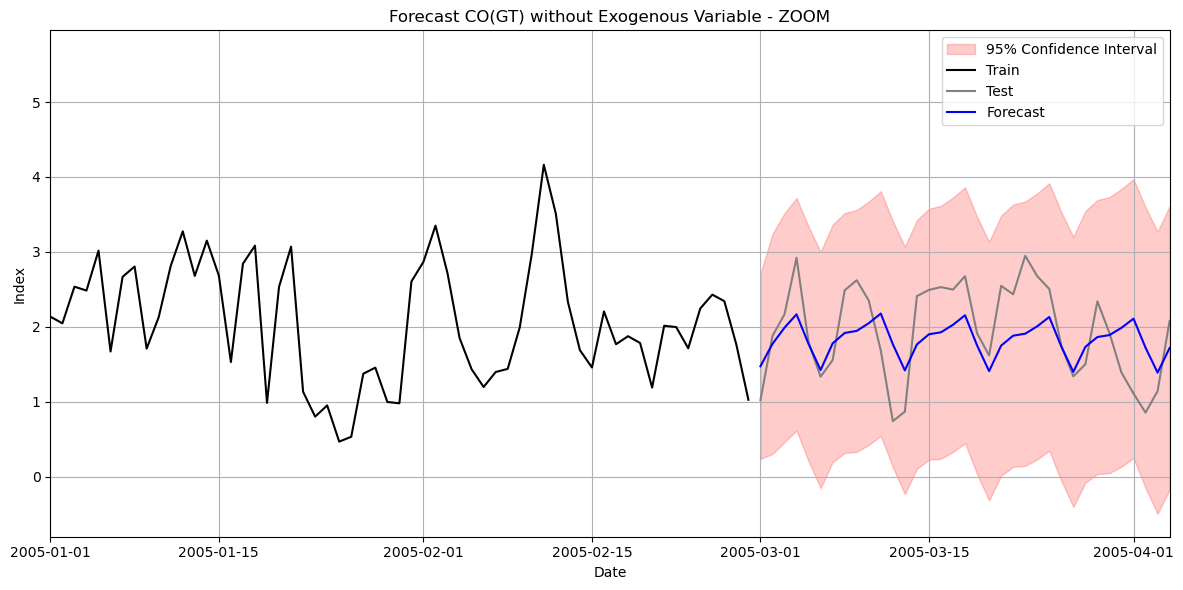

In [47]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['CO(GT)'], label='Train', color='black')       # Train
plt.plot(test.index, test['CO(GT)'], label='Test', color='gray')           # Test

plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')   # Forecast

plt.title('Forecast CO(GT) without Exogenous Variable - ZOOM')                      
plt.xlabel('Date')                                        
plt.ylabel('Index')  
plt.xlim(pd.to_datetime('2005-01-01'), pd.to_datetime('2005-04-04'))

# Set y-axis to avoid scientific notation
#plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

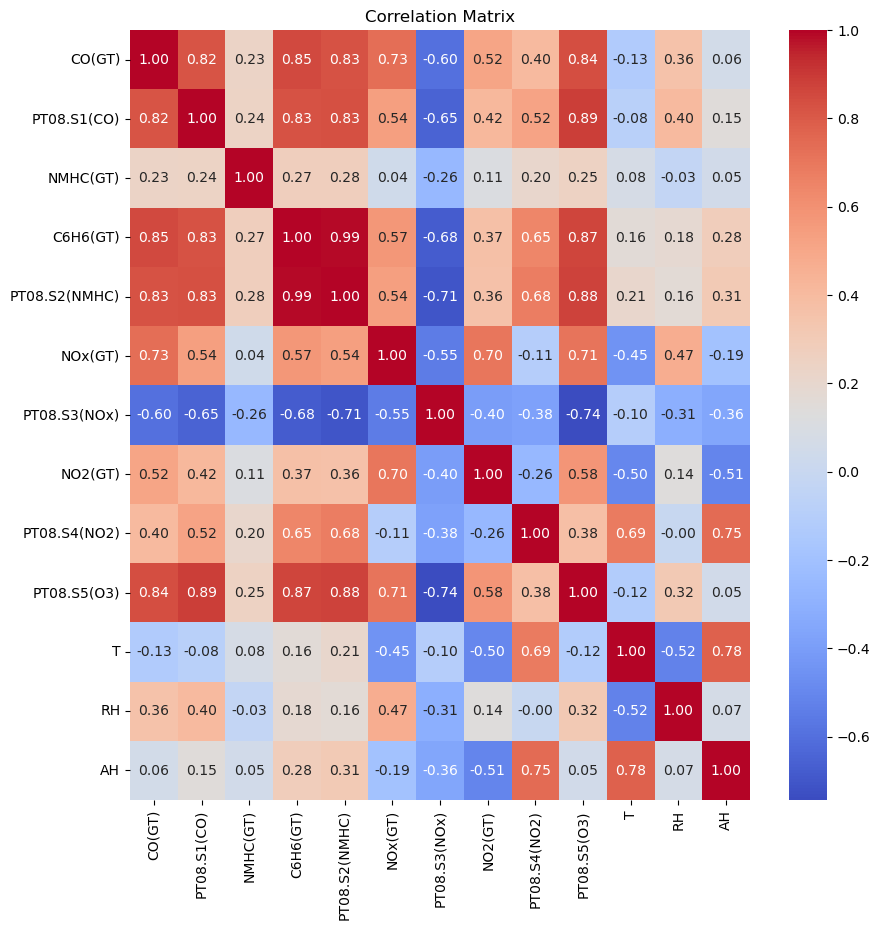

In [48]:
# Compute correlation matrix
c_matrix = train.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [49]:
# Identify columns where the first row value is >= 0.7 or <= -0.7
selected_columns = c_matrix.columns[np.logical_or(c_matrix.iloc[0] >= 0.70, 
                                                  c_matrix.iloc[0] <= -0.70)]

# Convert to list and remove target series
filtered_columns = [col for col in selected_columns if col != 'CO(GT)']

# Show the result
print(filtered_columns)

['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S5(O3)']


In [50]:
# Create a list of candidates
candidates = train[filtered_columns]

# Compute correlation matrix
corr_candidates = candidates.corr()

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_candidates.columns
vif_data["VIF"] = [round(variance_inflation_factor(corr_candidates.values, i), 2) for i in range(len(corr_candidates.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = corr_candidates.corr().round(2)
print(f'Correlation:\n{corr}')

                    VIF          Interpretation
Feature                                        
PT08.S1(CO)      234.57  High Multicollinearity
C6H6(GT)       23533.77  High Multicollinearity
PT08.S2(NMHC)  25695.63  High Multicollinearity
NOx(GT)          188.94  High Multicollinearity
PT08.S5(O3)     1179.55  High Multicollinearity

Correlation:
               PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S5(O3)
PT08.S1(CO)           1.00      0.67           0.70    -0.86         0.81
C6H6(GT)              0.67      1.00           1.00    -0.89         0.66
PT08.S2(NMHC)         0.70      1.00           1.00    -0.91         0.69
NOx(GT)              -0.86     -0.89          -0.91     1.00        -0.62
PT08.S5(O3)           0.81      0.66           0.69    -0.62         1.00


In [52]:
exog_data = train[['NOx(GT)']]    # Multiple column selection
endog_data = train['CO(GT)']      # Target variable selection

In [53]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(endog, exog, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]              # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]                # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 15 == 0:                                  # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(endog=endog,
                    exog=exog,
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(endog=endog_data, exog=exog_data , d=1, D=0, S=7)

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,7)
Running model #15 using SARIMA(0,1,0)(3,0,3,7)
Running model #30 using SARIMA(0,1,1)(3,0,2,7)
Running model #45 using SARIMA(0,1,2)(3,0,1,7)
Running model #60 using SARIMA(0,1,3)(3,0,0,7)
Running model #75 using SARIMA(1,1,0)(2,0,3,7)
Running model #90 using SARIMA(1,1,1)(2,0,2,7)
Running model #105 using SARIMA(1,1,2)(2,0,1,7)
Running model #120 using SARIMA(1,1,3)(2,0,0,7)
Running model #135 using SARIMA(2,1,0)(1,0,3,7)
Running model #150 using SARIMA(2,1,1)(1,0,2,7)
Running model #165 using SARIMA(2,1,2)(1,0,1,7)
Running model #180 using SARIMA(2,1,3)(1,0,0,7)
Running model #195 using SARIMA(3,1,0)(0,0,3,7)
Running model #210 using SARIMA(3,1,1)(0,0,2,7)
Running model #225 using SARIMA(3,1,2)(0,0,1,7)
Running model #240 using SARIMA(3,1,3)(0,0,0,7)
Running model #255 using SARIMA(3,1,3)(3,0,3,7)

Best models by AIC:
   index non-seasonal order seasonal order         AIC
0     59          (0, 1, 3)      (2, 0, 

In [54]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(0, 1, 3),               
                  seasonal_order=(2, 0, 3, 7),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            CO(GT)   No. Observations:                  356
Model:             SARIMAX(0, 1, 3)x(2, 0, 3, 7)   Log Likelihood                -161.485
Date:                           Fri, 09 May 2025   AIC                            342.969
Time:                                   14:30:36   BIC                            380.960
Sample:                               03-10-2004   HQIC                           358.123
                                    - 02-28-2005                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
NOx(GT)        0.0061      0.000     29.595      0.000       0.006       0.007
ma.L1         -0.2763      0.037     -7.381

In [55]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")


test_parameters(model_fit_M)

ar.S.L7 coefficient: 0.1658
ar.S.L7 95% CI: (-0.4766, 0.8082)
ar.S.L7 p-value: 0.6129
ar.S.L7 is statistically IRRELEVANT in the model.

ar.S.L14 coefficient: 0.3117
ar.S.L14 95% CI: (-0.0612, 0.6845)
ar.S.L14 p-value: 0.1013
ar.S.L14 is statistically IRRELEVANT in the model.

ma.S.L7 coefficient: -0.0489
ma.S.L7 95% CI: (-0.7055, 0.6077)
ma.S.L7 p-value: 0.8839
ma.S.L7 is statistically IRRELEVANT in the model.

ma.S.L14 coefficient: -0.2268
ma.S.L14 95% CI: (-0.5821, 0.1285)
ma.S.L14 p-value: 0.2109
ma.S.L14 is statistically IRRELEVANT in the model.

ma.S.L21 coefficient: -0.0047
ma.S.L21 95% CI: (-0.1551, 0.1457)
ma.S.L21 p-value: 0.9511
ma.S.L21 is statistically IRRELEVANT in the model.



In [56]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(0, 1, 3),               
                  seasonal_order=(0, 0, 0, 7),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                  356
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -174.492
Date:                Fri, 09 May 2025   AIC                            358.984
Time:                        14:30:36   BIC                            378.287
Sample:                    03-10-2004   HQIC                           366.666
                         - 02-28-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
NOx(GT)        0.0064      0.000     32.850      0.000       0.006       0.007
ma.L1         -0.3432      0.036     -9.404      0.000      -0.415      -0.272
ma.L2         -0.3203      0.046     -6.942      0.0

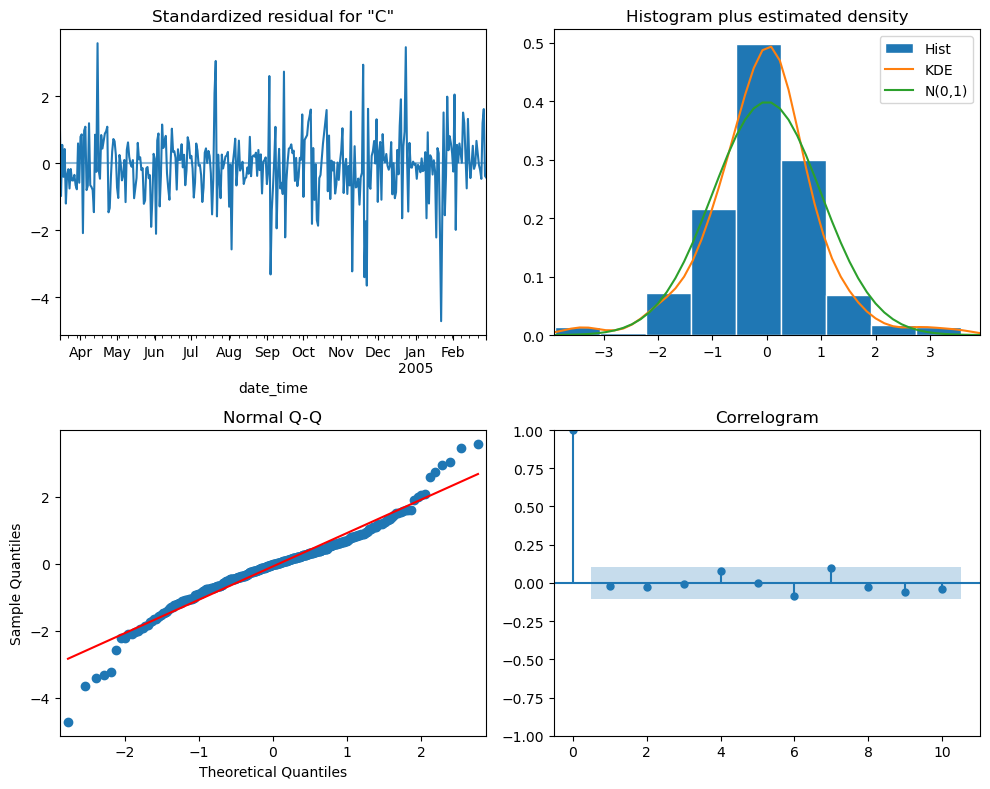

In [57]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [58]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.103172,0.748056
2,0.204896,0.902625
3,0.207755,0.976328
4,2.157633,0.706793
5,2.221559,0.817716
6,5.247890,0.512435
7,8.962866,0.255333
8,9.344310,0.314088
9,10.528747,0.309398
10,11.509770,0.319204


In [59]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 2.0019
Conclusion: No significant autocorrelation.


In [60]:
# Must match the structure of training exog
exog_test_M = test[['NOx(GT)']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['CO(GT)']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,RH,AH,Forecast S,Error,Lower 95% CI,Upper 95% CI,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
date_time,,,,,,,,,,,,,,,,,,,,,
2005-03-01,1.020833,820.166667,223.641573,2.933333,618.916667,185.721411,1191.833333,100.075497,699.083333,482.708333,...,35.104167,0.240004,1.472557,0.451724,0.235837,2.709277,1.139596,0.118763,0.361031,1.918162
2005-03-02,1.878261,978.782609,223.641573,7.756522,846.782609,334.752777,887.304348,151.426606,883.304348,1001.521739,...,31.478261,0.251748,1.771082,-0.107179,0.302871,3.239293,2.181362,0.303101,1.249897,3.112827
2005-03-03,2.166667,1184.291667,223.641573,8.150000,884.708333,375.721411,686.833333,157.700497,1162.416667,1304.250000,...,67.458333,0.577546,1.987961,-0.178706,0.459574,3.516348,2.479094,0.312427,1.511493,3.446695
2005-03-04,2.920833,1214.791667,223.641573,11.408333,994.916667,437.471411,650.458333,168.117164,1282.333333,1369.750000,...,62.191667,0.620279,2.166218,-0.754615,0.613837,3.718599,2.875128,-0.045706,1.902026,3.848229
2005-03-05,1.791304,1052.521739,223.641573,6.465217,824.869565,262.578864,778.869565,151.122258,1057.391304,919.173913,...,51.413043,0.543839,1.770033,-0.021272,0.203746,3.336319,1.753454,-0.037850,0.774883,2.732026


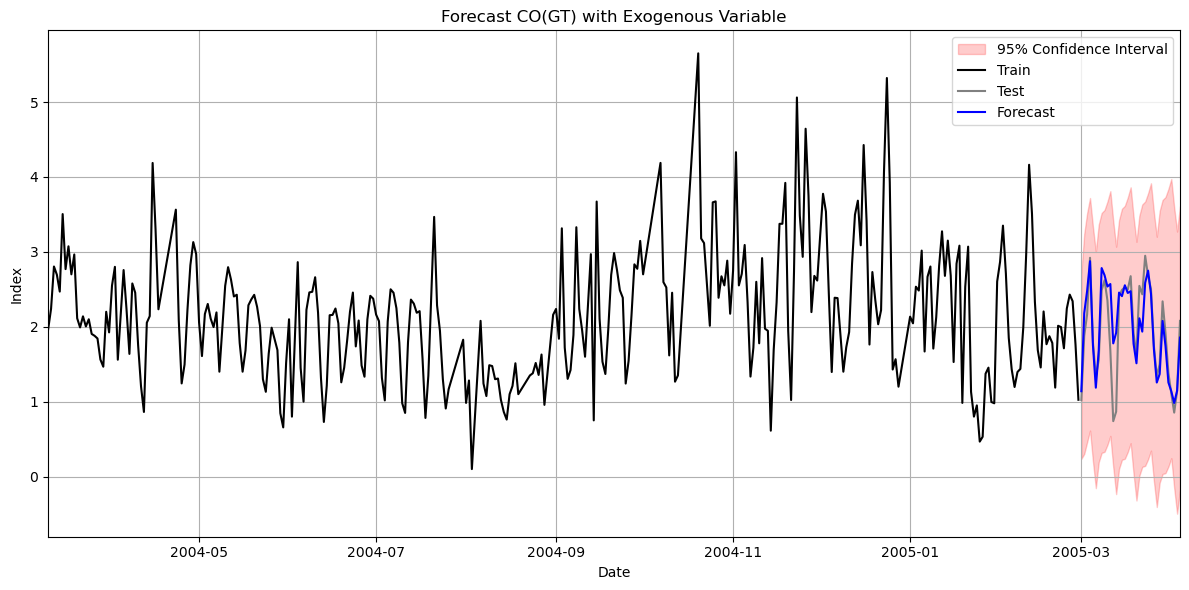

In [61]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['CO(GT)'], label='Train', color='black')       # Train
plt.plot(test.index, test['CO(GT)'], label='Test', color='gray')           # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')   # Forecast

plt.title('Forecast CO(GT) with Exogenous Variable')                      
plt.xlabel('Date')                                        
plt.ylabel('Index')  
plt.xlim(pd.to_datetime('2004-03-10'), pd.to_datetime('2005-04-04'))

# Set y-axis to avoid scientific notation
#plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

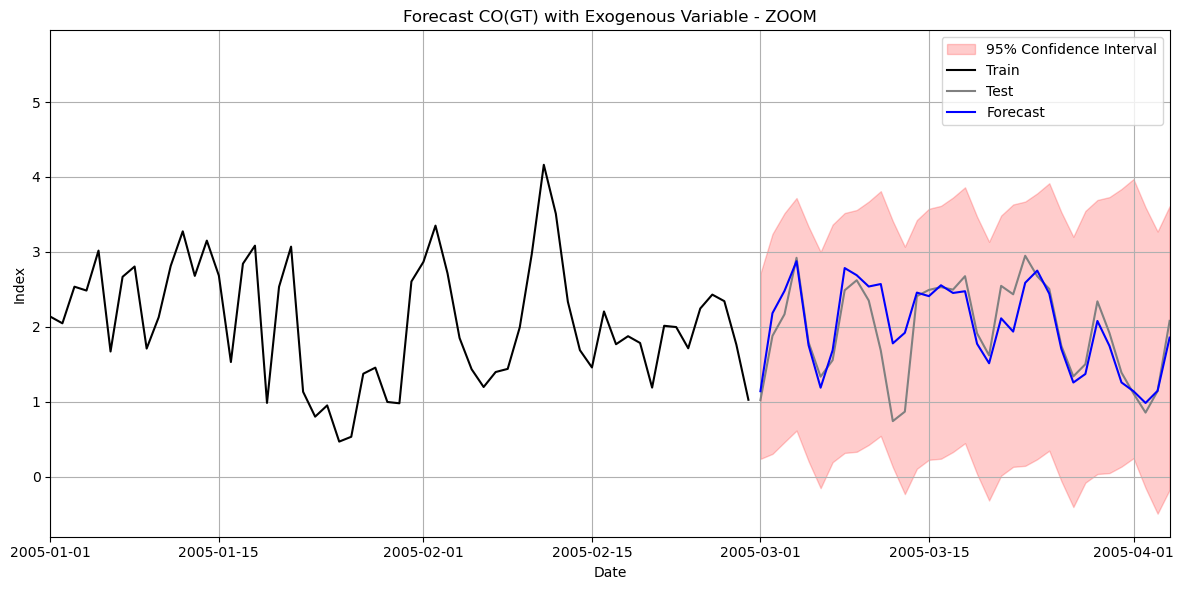

In [62]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['CO(GT)'], label='Train', color='black')       # Train
plt.plot(test.index, test['CO(GT)'], label='Test', color='gray')           # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')   # Forecast

plt.title('Forecast CO(GT) with Exogenous Variable - ZOOM')                      
plt.xlabel('Date')                                        
plt.ylabel('Index')  
plt.xlim(pd.to_datetime('2005-01-01'), pd.to_datetime('2005-04-04'))

# Set y-axis to avoid scientific notation
#plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['CO(GT)'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['CO(GT)'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['CO(GT)'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test['CO(GT)'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['CO(GT)'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['CO(GT)'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    #'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    #'MAPE': mape_m,
}

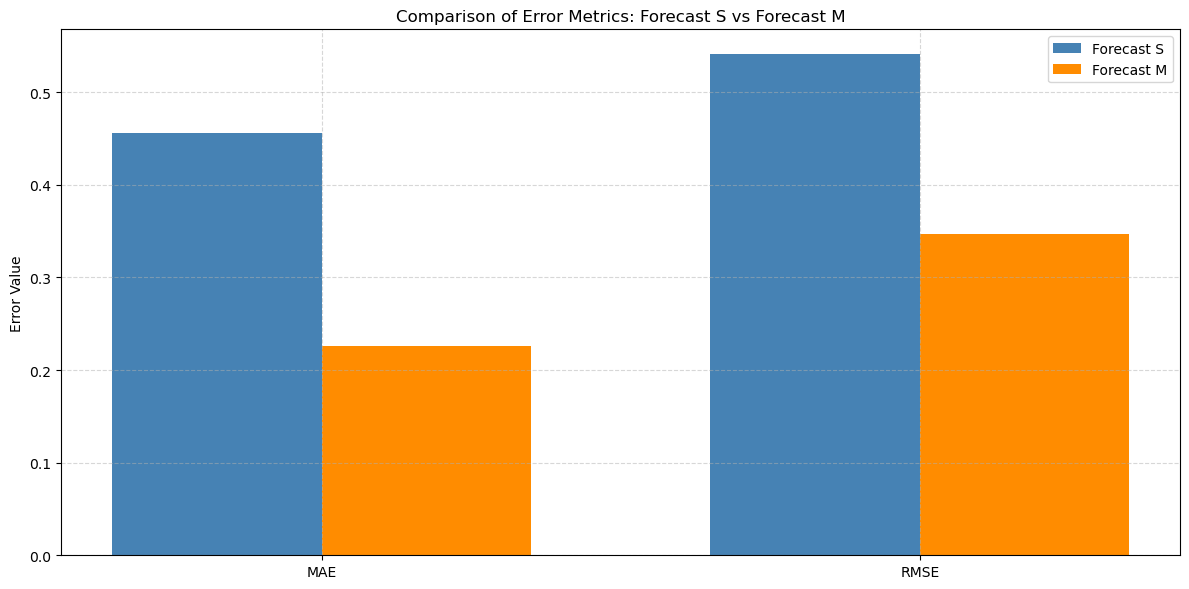

In [64]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [65]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,0.46,0.23
RMSE,0.54,0.35


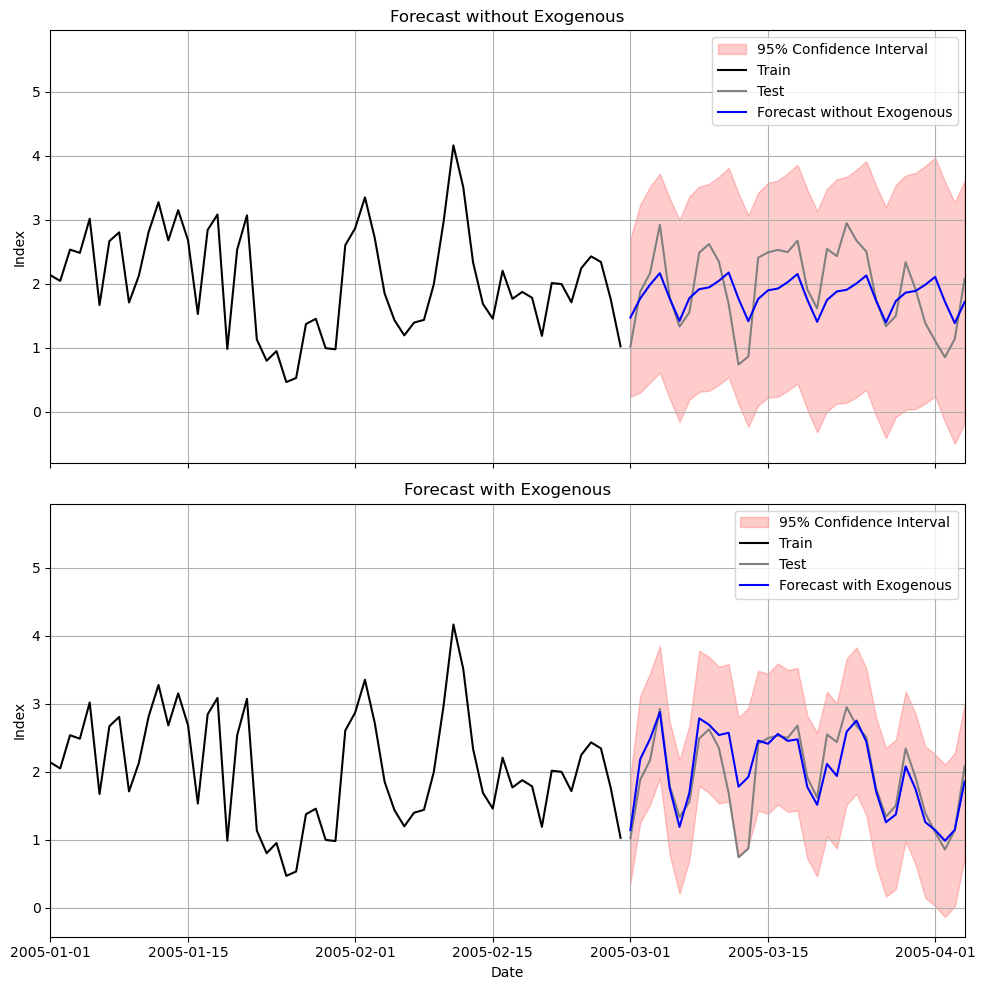

In [66]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast S) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['CO(GT)'], label='Train', color='black')
axes[0].plot(test.index, test['CO(GT)'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Index')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2005-01-01'), pd.to_datetime('2005-04-04'))
#axes[0].set_ylim(0, 60)

# --- Second Forecast (Forecast M) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['CO(GT)'], label='Train', color='black')
axes[1].plot(test.index, test['CO(GT)'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Index')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2005-01-01'), pd.to_datetime('2005-04-04'))
#axes[1].set_ylim(0, 60)

# Final layout
plt.tight_layout()
plt.show()

End.